# Vectorial PSF

This notebook shows simulation of vectorial PSF in a microscope given an aberration, same as in Boruah, B. R., and M. A. A. Neil. "Focal field computation of an arbitrarily polarized beam using fast Fourier transforms."

In [1]:
import numpy as np
import tensorflow as tf
from diffao.czt_tf import czt_factors, czt2d

from diffao.microscope_model import *
from diffao.wavefronts import Zernike, vortex

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
RES = 512
zernike = Zernike(resolution=RES)

Generating Zernikes on uniform grid...


## Necessary modifications

For this particular notebook the code from microscope_model is not suited: the intermediate calculated x- y- and z Cartesian electric field vectors are not saved. For plotting the electric field components this would be necessary, hence modification of ```MicroscopeObjective```

In [3]:
class MicroscopeObjective(tf.keras.layers.Layer):
    """Encapsulates microscope objective model with Debye-Wolf vectorial
    diffraction integral as described in Boruah et al. "Focal field computation
    of an arbitrarily polarized beam using fast Fourier transforms."
    Optics communications (2009).
    """
    def __init__(self, d_pupil: float,
                 f: float,
                 n_t: float,
                 wavelength: float,
                 fov_size: float,
                 fov_res: int = 512,
                 simulated_planes_z: list = [0]) -> None:
        """
        Precomutes model parameter from parameters of the focused beam and
        of the required region of simulation.

        Args:
            d_pupil: Diameter of the objective pupil.
            f: Focal length of the objective.
            n_t: Refractive index of the medium.
            wavelength: Light wavelength lambda.
            fov_size: Size of simulated imaged field of view.
            fov_res: Resolution of the rendered FOV discretization.
            simulated_planes_z: List of offsets to simulated planes. With
                [0] only focal plane is simulated. Example: [-2*um, 0, 2*um]
                simulates 2 more z-planes at +-2 um.
        """
        super(MicroscopeObjective, self).__init__()
        self.n_t = n_t
        self.f = f
        self.wl = wavelength
        self.d = d_pupil
        self.fov_size = fov_size
        self.fov_res = fov_res
        # Angle of convergence of the beam:
        self.max_th = np.math.atan(self.d / (2 * self.f))

        # Numerical aperture:
        numerical_aperture = self.n_t * np.sin(np.math.atan(self.d / (2 * self.f)))
        print(f'Initialized Debye model with NA={np.round(numerical_aperture, 4)},\n'
              f'Angular aperture alpha={np.round(2 * self.max_th, 4)}')

        self.fov_scale = tf.constant(self.fov_res / self.fov_size, dtype=DT_FL)  # [px/um]

        # Calculating wave frequencies at FOV given its resolution and scale:
        k_0 = self.n_t * 2 * np.pi / self.wl  # Wavenumber [rad/um]
        k0_px = k_0 / (2 * np.pi) / self.fov_scale  # Cyclic freq fft units [cycles/px]

        # Maximal radial spatial frequency possible in [cycles / px]
        k_r_px_max = (k0_px * np.sin(self.max_th)).numpy()
        self.k_r_px_max = k_r_px_max  # Bandwidth

        # Initializing k-space meshgrids corresponding to the bandwidth:
        k_px = np.linspace(-k_r_px_max, k_r_px_max, self.fov_res)
        kxx_px, kyy_px = np.meshgrid(k_px, k_px)    # Careful with meshgrid/mgrid!
        krr_px = np.sqrt(kxx_px ** 2 + kyy_px ** 2)
        self.kzz_px = np.sqrt(k0_px ** 2 - krr_px ** 2)
        self.kzz_px[np.isnan(self.kzz_px)] = 0
        # Meshgrid on k-space with corresponding theta angles:
        self.thh_k = np.arctan2(krr_px, self.kzz_px)
        # Meshgrid on k-space with corresponding phi angles:
        self.phh_k = np.arctan2(kyy_px, kxx_px)
        # Bandwidth is basically a mask where spatial frequencies exist in k-space:
        self.bandwidth = self.thh_k < self.max_th

        # These constants used to map pupil function onto k-space,
        # see Boruah 2009 for derivation and details:
        self.Gx = np.sqrt(np.cos(self.thh_k)) *\
            (np.cos(self.thh_k) + (1 - np.cos(self.thh_k)) *
             np.sin(self.phh_k) ** 2) / np.cos(self.thh_k)
        self.Gy = np.sqrt(np.cos(self.thh_k)) *\
            ((np.cos(self.thh_k) - 1) * np.cos(self.phh_k) *
             np.sin(self.phh_k)) / np.cos(self.thh_k)
        self.Gz = -np.sqrt(np.cos(self.thh_k)) *\
            np.sin(self.thh_k) * np.cos(self.phh_k) / np.cos(self.thh_k)

        ## Initializing TF constants and variables:
        self.Gx = tf.constant(self.Gx, dtype=DT_CX)
        self.Gy = tf.constant(self.Gy, dtype=DT_CX)
        self.Gz = tf.constant(self.Gz, dtype=DT_CX)
        
        self.z_planes = tf.constant(simulated_planes_z, dtype=DT_FL)
        self.bandwidth = tf.constant(self.bandwidth, dtype=DT_CX)
        self.kzz_px = tf.constant(self.kzz_px, dtype=DT_CX)

        self.apodization = tf.Variable(
            tf.ones([self.fov_res, self.fov_res]),
            trainable=True,
            name='ApodizationFunction')
        self.aberration = tf.Variable(
            tf.zeros([self.fov_res, self.fov_res]),
            trainable=True,
            name='PhaseAberration')

        # Initial object function, just a single point in the center:
        of = np.zeros([self.fov_res, self.fov_res])
        of[self.fov_res // 2, self.fov_res // 2] = 1.0
        self.object_function = tf.Variable(of, dtype=DT_FL)

        # Used to store PSF intensity as one of optimization targets:
        self.total_intensity = tf.Variable(0, dtype=DT_FL)

        # Init CZT transform
        self.czt_factors = czt_factors(
            self.fov_res, self.fov_res,
            w_begin=-k_r_px_max, w_end=k_r_px_max, L=1024)


    def sim(self, z_offset: tf.Tensor, pupil_x: tf.Tensor, pupil_y: tf.Tensor) -> tf.Tensor:
        """Computes vectorial diffraction at specified plane for X- and Y
        polarizations of the pupil.
        Args:
            z_offset: Offset of the simulated plane from the focal.
            pupil_x: Tensor [y, x], complex, for pupil x-polarization
            pupil_y: Tensor [y, x], complex, for pupil y-polarization

        Returns:
            Tensor [] with PSF at the requested plane.
        """

        # Propagation factor to the target z-plane:
        z_px = tf.complex(z_offset * self.fov_scale, tf.zeros_like(z_offset))
        prop_exp = tf.exp(2j * np.pi * self.kzz_px * z_px)  # [!] 2*pi factor
        # as kzz_px is in [cycles/px] and exponent takes rads [!]

        abb = tf.complex(tf.abs(self.apodization), tf.zeros_like(self.apodization)) * tf.exp(
            tf.complex(tf.zeros_like(self.aberration), self.aberration))

        # Refer to Boruah 2009.
        # Compute x- y- z-complonents of electic field at destination plane
        # induced by X-polarization of the pupil function:
        l0x = pupil_x * abb * prop_exp * self.bandwidth
        EXx = czt2d(l0x * self.Gx, self.czt_factors)
        EXy = czt2d(l0x * self.Gy, self.czt_factors)
        EXz = czt2d(-l0x * self.Gz, self.czt_factors)
        # induced by Y-polarization of the pupil function:
        l0y = pupil_y * abb * prop_exp * self.bandwidth
        EYx = czt2d(-l0y * tf.image.rot90(tf.expand_dims(self.Gy, axis=-1), k=1)[..., 0],
                    self.czt_factors)
        EYy = czt2d(l0y * tf.image.rot90(tf.expand_dims(self.Gx, axis=-1), k=1)[..., 0],
                    self.czt_factors)
        EYz = czt2d(l0y * tf.image.rot90(tf.expand_dims(self.Gz, axis=-1), k=1)[..., 0],
                    self.czt_factors)
        
        #self.exx, self.exy, self.exz, self.eyx, self.eyy, self.eyz = 
        
        self.pupils = [
            (l0x * self.Gx), (l0x * self.Gy), (-l0x * self.Gz),
            (-l0y * tf.image.rot90(tf.expand_dims(self.Gy, axis=-1), k=1)[..., 0]), 
            (l0y * tf.image.rot90(tf.expand_dims(self.Gx, axis=-1), k=1)[..., 0]), 
            (l0y * tf.image.rot90(tf.expand_dims(self.Gz, axis=-1), k=1)[..., 0]) 
        ]
        
        self.exx = [
            EXx, EXy, EXz, EYx, EYy, EYz
        ]
        # Aggregate all contributions to PSF intensity and square for fluorescence
        psf = tf.square((tf.square(tf.abs(EXx + EYx)) + tf.square(tf.abs(EXy + EYy)) + tf.square(
            tf.abs(EXz + EYz))) / 10e10)  # overflow protection

        self.total_intensity.assign_add(tf.reduce_sum(psf))
        # TODO: individual intensities for each batch and slice

        return tf.abs(tf.signal.fftshift(tf.signal.fft2d(tf.signal.fft2d(
                tf.complex(psf, tf.zeros_like(psf))) * tf.signal.fft2d(
            tf.complex(tf.abs(self.object_function),
                       tf.zeros_like(self.object_function)))))) / 1e5


    def sim_vol(self, pupil_xy: tf.Tensor) -> tf.Tensor:
        """Computes image for every z-plane of the simulation:
        Args:
            pupil_xy: Tensor [y, x, polarization], complex.

        Returns: Tensor [z, y, x], float, intensity of the fluorescence.
        """
        pupil_x, pupil_y = pupil_xy[..., 0], pupil_xy[..., 1]
        return tf.map_fn(lambda d: self.sim(d, pupil_x, pupil_y), self.z_planes)


    def call(self, batch_pupil_xy: tf.Tensor) -> tf.Tensor:
        """Computes volume simulation for whole input batch

        Args:
            batch_pupil_xy: Tensor [BS, y, x, polarization], complex.

        Returns:
            Tensor [BS, z, y, x] with simulated volume intensity for each pupil
                function of the batch.
        """
        self.total_intensity.assign(0)
        self.eex = []
        return tf.map_fn(self.sim_vol, batch_pupil_xy, dtype=DT_FL)

In [4]:
# For PSF we model only objective
# Parameters f and d_pupil are chosen such that alpha = 1.125 as in Bourah.
mo = MicroscopeObjective(
            d_pupil=5.422 * MM,
            f=4.3 * MM,
            n_t=1.33,   # Water
            wavelength=920 * NM,
            fov_size=20* UM,
            fov_res=512,
            simulated_planes_z=[0]
)

Initialized Debye model with NA=0.7093,
Angular aperture alpha=1.125
Instantitaing CZT with float32 (complex64) floating point precision.


In [5]:
# Aberration magnitudes used in Boruah are +-1, +-0.4, and 0.0 (rads).
# Here we convert them to wavelengths as our Zernike generator expects.
MAGNITUDES = [-1.0/(np.pi*2), -0.4/(np.pi*2), 0.0, 0.4/(np.pi*2), 1.0/(np.pi*2)]

In [6]:
def stack_all(results):
    """ Function for stacking all foci into one image panel for display.
    """
    n_results = len(results)
    cols = []
    for view in np.split(np.array(range(n_results)), len(range(n_results//len(MAGNITUDES)))):
        cols.append(np.vstack(results[view]))
    return(np.hstack(cols))

(<matplotlib.image.AxesImage at 0x22868648c10>, Text(0, 0.5, 'Ix + Iy + Iz'))

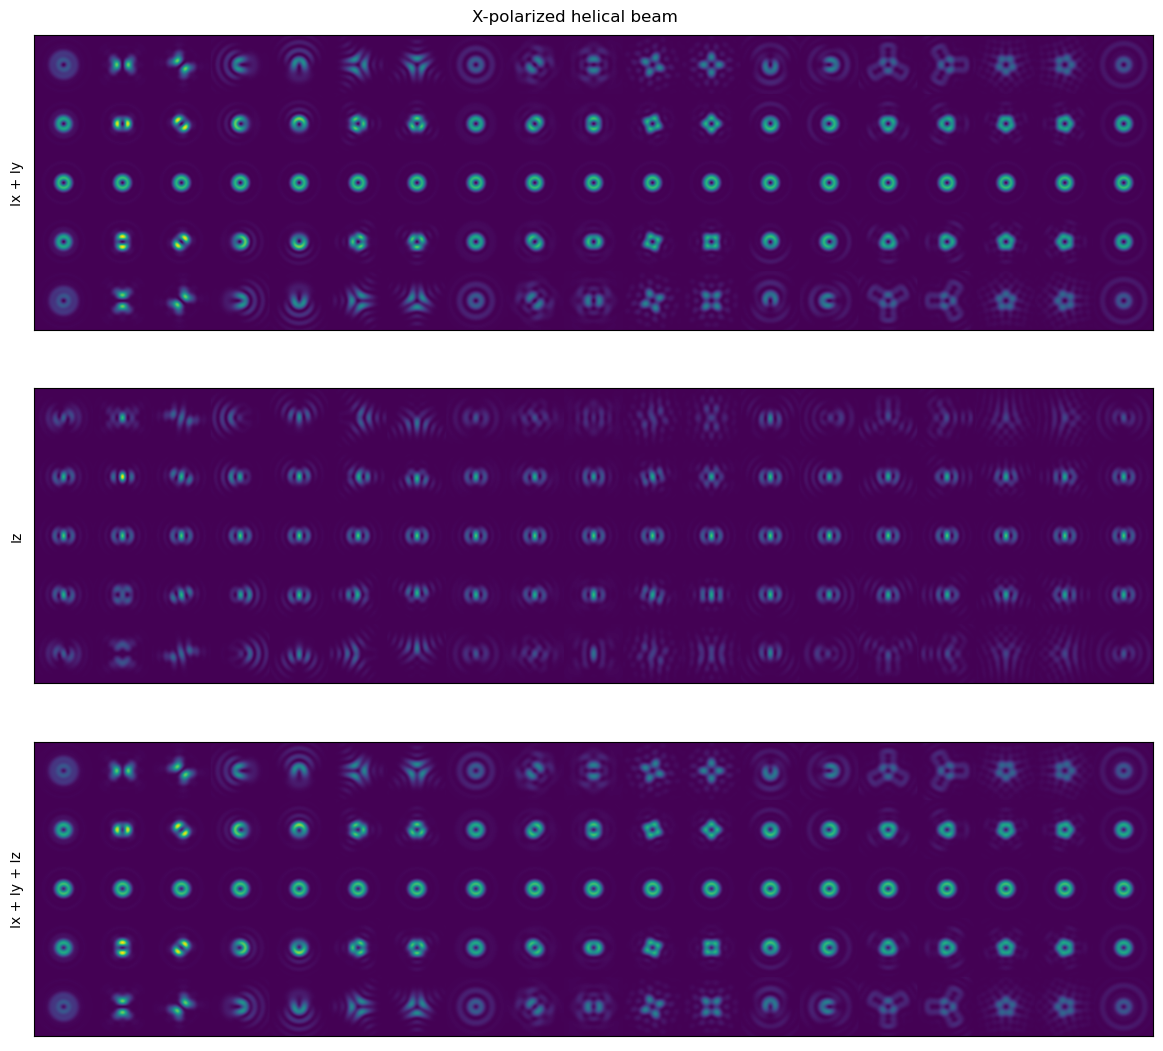

In [9]:
beam = LinearBeam()
helix = vortex(resolution=512)

results_ixy = []
results_iz = []
results_ixyz = []
C = 180
for _z in range(3, 22): # Zernike aberrations shown in Boruah
    for m in MAGNITUDES:
        zc = list(np.zeros(30))
        zc[_z] = m
        mo(beam(np.expand_dims(np.asarray(np.exp(1j*(zernike.phase(zc) + helix)), np.complex64), 0)))
        
        EXx, EXy, EXz, EYx, EYy, EYz = mo.exx
        Ixy = np.abs(EXx+EYx)**2+np.abs(EXy+EYy)**2
        Iz = np.abs(EXz+EYz)**2
        Ixyz = Ixy + Iz
        results_ixy.append(Ixy[C:-C, C:-C])
        results_iz.append(Iz[C:-C, C:-C])
        results_ixyz.append(Ixyz[C:-C, C:-C])
    print(f'z: {_z}', end='\r')
results_ixy = np.array(results_ixy)
results_iz = np.array(results_iz)
results_ixyz = np.array(results_ixyz)


plt.figure(figsize=(15, 13))
plt.suptitle('X-polarized helical beam', y=0.9)
plt.subplot(311), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixy)), plt.ylabel('Ix + Iy')
plt.subplot(312), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_iz)), plt.ylabel('Iz')
plt.subplot(313), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixyz)), plt.ylabel('Ix + Iy + Iz')

(<matplotlib.image.AxesImage at 0x228006a4190>, Text(0, 0.5, 'Ix + Iy + Iz'))

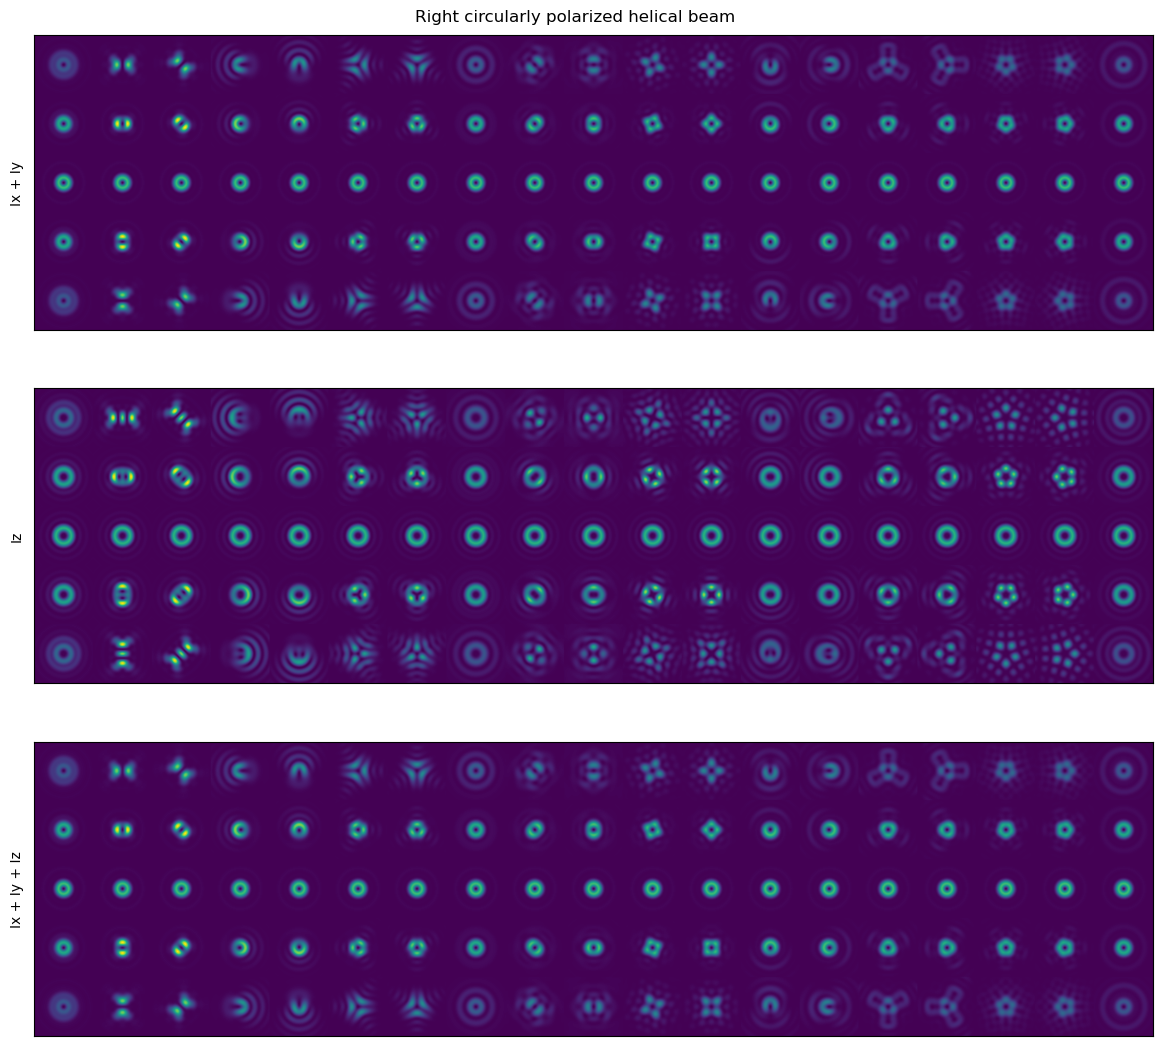

In [10]:
beam = CircularBeam()
helix = vortex(resolution=512)

results_ixy = []
results_iz = []
results_ixyz = []
C = 180
for _z in range(3, 22): # Zernike aberrations shown in Boruah
    for m in MAGNITUDES:
        zc = list(np.zeros(30))
        zc[_z] = m
        mo(beam(np.expand_dims(np.asarray(np.exp(1j*(zernike.phase(zc) + helix)), np.complex64), 0)))
        
        EXx, EXy, EXz, EYx, EYy, EYz = mo.exx
        Ixy = np.abs(EXx+EYx)**2+np.abs(EXy+EYy)**2
        Iz = np.abs(EXz+EYz)**2
        Ixyz = Ixy + Iz
        results_ixy.append(Ixy[C:-C, C:-C])
        results_iz.append(Iz[C:-C, C:-C])
        results_ixyz.append(Ixyz[C:-C, C:-C])
    print(f'z: {_z}', end='\r')
results_ixy = np.array(results_ixy)
results_iz = np.array(results_iz)
results_ixyz = np.array(results_ixyz)

plt.figure(figsize=(15, 13))
plt.suptitle('Right circularly polarized helical beam', y=0.9)
plt.subplot(311), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixy)), plt.ylabel('Ix + Iy')
plt.subplot(312), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_iz)), plt.ylabel('Iz')
plt.subplot(313), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixyz)), plt.ylabel('Ix + Iy + Iz')

(<matplotlib.image.AxesImage at 0x22800763820>, Text(0, 0.5, 'Ix + Iy + Iz'))

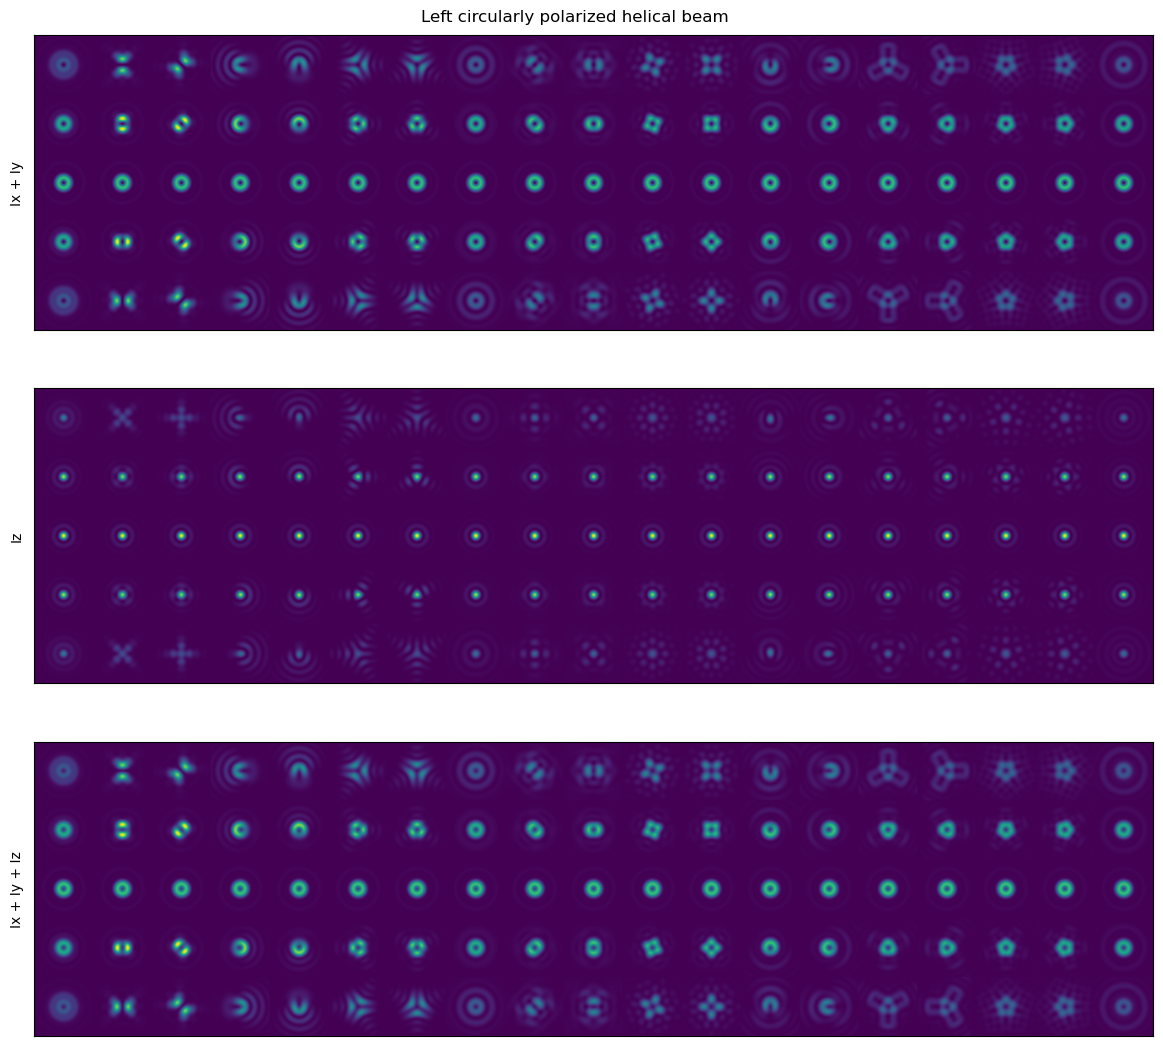

In [11]:
beam = CircularBeam()
helix = -vortex(resolution=512)

results_ixy = []
results_iz = []
results_ixyz = []
C = 180
for _z in range(3, 22): # Zernike aberrations shown in Boruah
    for m in MAGNITUDES:
        zc = list(np.zeros(30))
        zc[_z] = m
        mo(beam(np.expand_dims(np.asarray(np.exp(1j*(zernike.phase(zc) + helix)), np.complex64), 0)))
        
        EXx, EXy, EXz, EYx, EYy, EYz = mo.exx
        Ixy = np.abs(EXx+EYx)**2+np.abs(EXy+EYy)**2
        Iz = np.abs(EXz+EYz)**2
        Ixyz = Ixy + Iz
        results_ixy.append((Ixy)[C:-C, C:-C])
        results_iz.append((Iz)[C:-C, C:-C])
        results_ixyz.append((Ixyz)[C:-C, C:-C])
    print(f'z: {_z}', end='\r')
results_ixy = np.array(results_ixy)
results_iz = np.array(results_iz)
results_ixyz = np.array(results_ixyz)

plt.figure(figsize=(15, 13))
plt.suptitle('Left circularly polarized helical beam', y=0.9)
plt.subplot(311), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixy)), plt.ylabel('Ix + Iy')
plt.subplot(312), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_iz)), plt.ylabel('Iz')
plt.subplot(313), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixyz)), plt.ylabel('Ix + Iy + Iz')

(<matplotlib.image.AxesImage at 0x2280083f520>, Text(0, 0.5, 'Ix + Iy + Iz'))

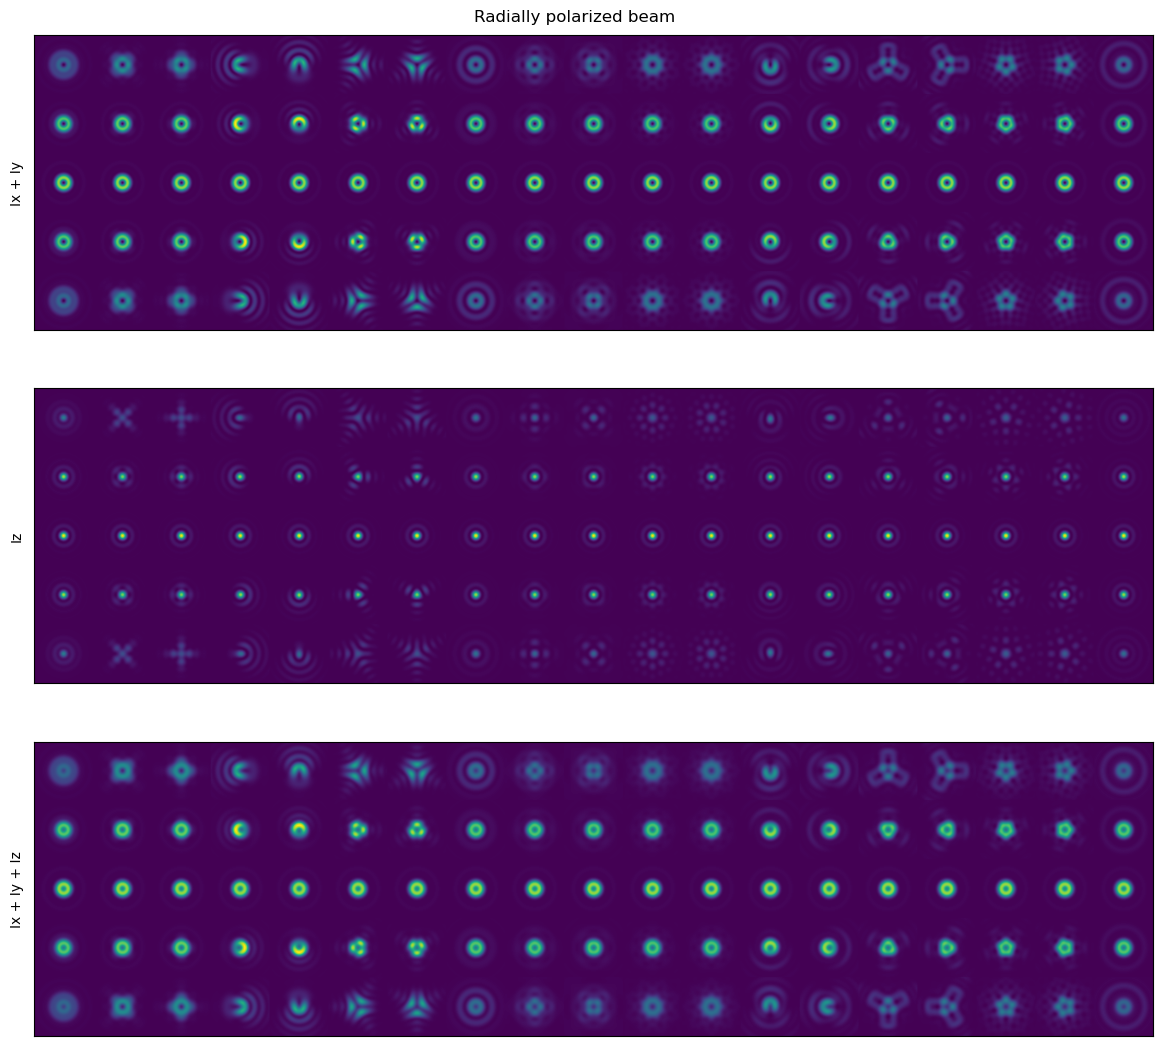

In [12]:
yy, xx = np.mgrid[-1:1:RES*1j, -1:1:RES*1j]
beam = RadialBeam(xx, yy)

results_ixy = []
results_iz = []
results_ixyz = []
C = 180
for _z in range(3, 22): # Zernike aberrations shown in Boruah
    for m in MAGNITUDES:
        zc = list(np.zeros(30))
        zc[_z] = m
        mo(beam(np.expand_dims(np.asarray(np.exp(1j*(zernike.phase(zc))), np.complex64), 0)))
        
        EXx, EXy, EXz, EYx, EYy, EYz = mo.exx
        Ixy = np.abs(EXx+EYx)**2+np.abs(EXy+EYy)**2
        Iz = np.abs(EXz+EYz)**2
        Ixyz = Ixy + Iz
        results_ixy.append(Ixy[C:-C, C:-C]) # Normalization for displaying all foci in one panel
        results_iz.append(Iz[C:-C, C:-C])
        results_ixyz.append(Ixyz[C:-C, C:-C])
    print(f'z: {_z}', end='\r')
results_ixy = np.array(results_ixy)
results_iz = np.array(results_iz)
results_ixyz = np.array(results_ixyz)

plt.figure(figsize=(15, 13))
plt.suptitle('Radially polarized beam', y=0.9)
plt.subplot(311), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixy)), plt.ylabel('Ix + Iy')
plt.subplot(312), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_iz)), plt.ylabel('Iz')
plt.subplot(313), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixyz)), plt.ylabel('Ix + Iy + Iz')

**This one simulation (radially polarized beam) diverges from results in Boruah** *

(<matplotlib.image.AxesImage at 0x22800e4cdf0>, Text(0, 0.5, 'Ix + Iy + Iz'))

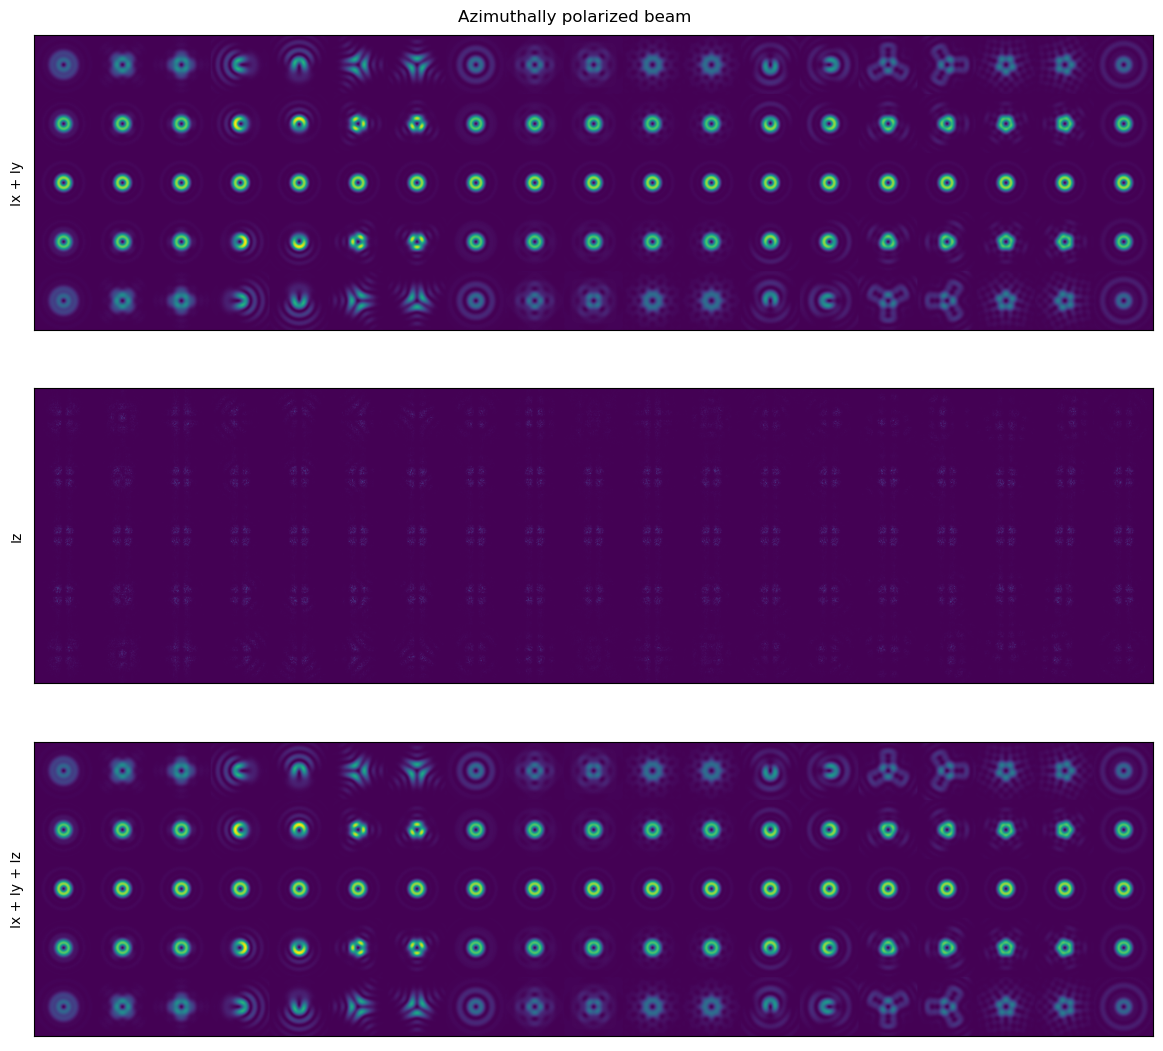

In [13]:
yy, xx = np.mgrid[-1:1:RES*1j, -1:1:RES*1j]
beam = AzimuthalBeam(xx, yy)

results_ixy = []
results_iz = []
results_ixyz = []
C = 180
for _z in range(3, 22): # Zernike aberrations shown in Boruah
    for m in MAGNITUDES:
        zc = list(np.zeros(30))
        zc[_z] = m
        mo(beam(np.expand_dims(np.asarray(np.exp(1j*(zernike.phase(zc))), np.complex64), 0)))
        
        EXx, EXy, EXz, EYx, EYy, EYz = mo.exx
        Ixy = np.abs(EXx+EYx)**2+np.abs(EXy+EYy)**2
        Iz = np.abs(EXz+EYz)**2
        Ixyz = Ixy + Iz
        results_ixy.append(Ixy[C:-C, C:-C]) # Normalization for displaying all foci in one panel
        results_iz.append(Iz[C:-C, C:-C])
        results_ixyz.append(Ixyz[C:-C, C:-C])
    print(f'z: {_z}', end='\r')
results_ixy = np.array(results_ixy)
results_iz = np.array(results_iz)
results_ixyz = np.array(results_ixyz)

plt.figure(figsize=(15, 13))
plt.suptitle('Azimuthally polarized beam', y=0.9)
plt.subplot(311), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixy)), plt.ylabel('Ix + Iy')
plt.subplot(312), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_iz)), plt.ylabel('Iz')
plt.subplot(313), plt.gca().get_xaxis().set_ticks([]), plt.gca().get_yaxis().set_ticks([])
plt.imshow(stack_all(results_ixyz)), plt.ylabel('Ix + Iy + Iz')